In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

import emcee
import corner

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel, SingleStarModel, get_ichrone

from stardate.lhf import gyro_model_rossby, gyro_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP", "G"]
mist = MIST_Isochrone(bands)
mist.initialize()

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Start by simulating data using MIST models. Simulate EEPs, ages, fehs, distances. Ages are drawn from a very narrow Gaussian.

In [3]:
N = 1000

# Simulate parameters
np.random.seed(42)
eep = np.random.uniform(195, 480, size=N)
# age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
age = np.random.randn(N)*1e-4 + 10 # everything has an age of about 10 Gyr
feh = np.random.uniform(-.2, .2, size=N)
mass = mist.interp_value([eep, age, feh], ["mass"])
d_kpc = np.random.uniform(.01, 1, size=N)
d_pc = d_kpc*1e3
av = np.random.uniform(0, .1, size=N)

# Calculate observables from these simulated parameters
logg, teff, feh, BP, RP, G = [np.zeros(N) for i in range(6)]
for i in trange(N):
    teff[i], logg[i], feh[i], bands = mist.interp_mag(
        [eep[i], age[i], feh[i], d_pc[i], av[i]], 
        ["BP", "RP", "G"])
    BP[i], RP[i], G[i] = bands
    parallax = 1./d_kpc

100%|██████████| 1000/1000 [00:00<00:00, 18644.58it/s]


Plot on a CMD

Text(0, 0.5, 'log g')

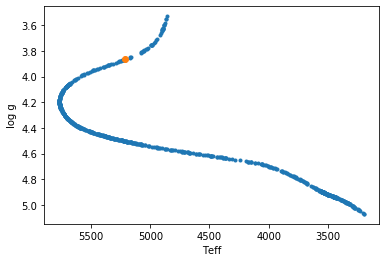

In [4]:
i = 1
plt.plot(teff, logg, ".")
plt.plot(teff[i], logg[i], "o")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Teff")
plt.ylabel("log g")

Now try to infer the EEP, age, feh, distance and Av of just one of these stars. Set up the parameters and the observables.

In [197]:
observables = {"teff": (teff[i]+np.random.randn(1)*10, 10),
               "logg": (logg[i]+np.random.randn(1)*.01, .01),
               "feh": (feh[i]+np.random.randn(1)*.01, .01),
               "parallax": (parallax[i]+np.random.randn(1)*.0001, .0001)}

params = np.array([eep[i], age[i], feh[i], d_pc[i], av[i]])

# Log-uniform prior on distance
lnparams = np.array([eep[i], age[i], feh[i], np.log(d_pc[i]), av[i]])

mod = SingleStarModel(mist, **observables)

Test isochrone's built-in functions. Make sure these don't return NaNs.

In [198]:
mod.lnprior(params), mod.lnlike(params), mod.lnpost(params)

(-19.40815975623518, -22.4571253370189, -41.86528509325408)

We want custom priors, so let's define our own posterior function.

In [199]:
def lnprior(params):
    # params = eep, age, feh, d, av
    
    # Set uniform priors on everything (change this later)
    if params[0] > 195 and params[0] < 600 and params[1] > -1 and \
        params[1] < 10.2 and params[2] > -.3 and params[2] < .3 \
        and params[3] > 2 and params[3] < 8 and params[4] > 0 and params[4] < .2:
        return 0
    else:
        return -np.inf

def lnprob(params, mod):
    prior = lnprior(params)
    p = params*1
    p[3] = np.exp(params[3])
    like = mod.lnlike(p)
    if not np.isfinite(like):
        return -np.inf
    else:
        return like + prior
#     return(mod.lnpost(params))  # This function uses priors built-into isochrones.py

# Test the logprob returns a reasonable number (not NaNs or infs)
print(lnprob(lnparams, mod))

-22.4571253370202


Run emcee.

In [200]:
ndim, nwalkers = 5, 50
p0 = np.random.randn(nwalkers, ndim)*1e-3 + lnparams

# Should definitely have more samples for the final run!
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[mod])
sampler.run_mcmc(p0, 1000);

Check the posteriors.

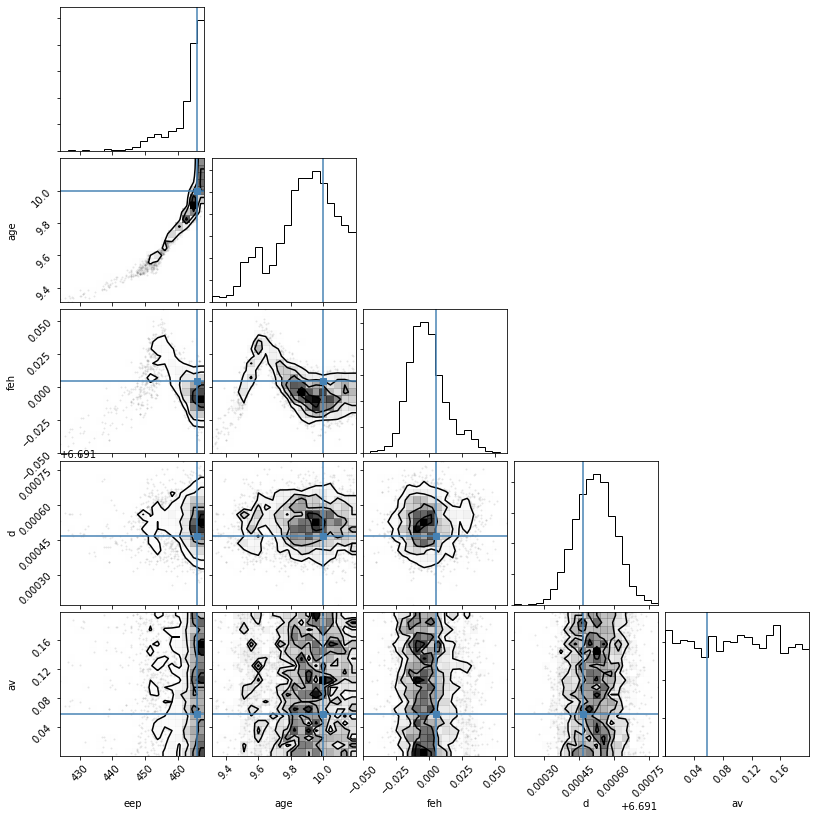

In [201]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["eep", "age", "feh", "d", "av"]
fig = corner.corner(flat_samples, labels=labels, truths=lnparams)

Now lets do exactly the same thing but where we model two stars at once. The hard part here is code management -- I'm sure there is a much more elgant way to code this but I'm doing it quickly :-).

In [202]:
i1 = 1
observables1 = {"teff": (teff[i1]+np.random.randn(1)*10, 10),
               "logg": (logg[i1]+np.random.randn(1)*.01, .01),
               "feh": (feh[i1]+np.random.randn(1)*.01, .01),
               "parallax": (parallax[i1]+np.random.randn(1)*.0001, .0001)}

i2 = 2
observables2 = {"teff": (teff[i2]+np.random.randn(1)*10, 10),
               "logg": (logg[i2]+np.random.randn(1)*.01, .01),
               "feh": (feh[i2]+np.random.randn(1)*.01, .01),
               "parallax": (parallax[i2]+np.random.randn(1)*.0001, .0001)}

params2 = np.array([eep[i1], eep[i2], age[i1], age[i2], feh[i1], feh[i2],
                    d_pc[i1], d_pc[i2], av[i1], av[i2]])

# Log-uniform prior on distance
lnparams2 = np.array([eep[i1], eep[i2], age[i1], age[i2], feh[i1], feh[i2],
                      np.log(d_pc[i1]), np.log(d_pc[i2]), av[i1], av[i2]])

mod1 = SingleStarModel(mist, **observables1)
mod2 = SingleStarModel(mist, **observables2)

In [203]:
def lnprior2(params):
    # params = eep1, eep2, age1, age2, feh1, feh2, d1, d2, av1, av2
    
    # Set uniform priors on everything (change this later). There is definitely a more elegant way to code this!
    if np.all(params[:2] > 195) and np.all(params[:2] < 600) and np.all(params[2:4] > -1) \
        and np.all(params[2:4] < 10.2) and np.all(params[4:6] > -.3) and np.all(params[4:6] < .3) \
        and np.all(params[6:8] > 2) and np.all(params[6:8] < 8) and np.all(params[8:10] > 0) \
        and np.all(params[8:10] < .2):
        return 0
    else:
        return -np.inf

def lnprob2(params, mod1, mod2):
    prior = lnprior2(params)
    p = params*1
    p[6:8] = np.exp(params[6:8])
    like1 = mod1.lnlike(p[::2])
    like2 = mod2.lnlike(p[1::2])
    if not np.isfinite(like1) or not np.isfinite(like2):
        return -np.inf
    else:
        return like1 + like2 + prior

# Test the logprob returns a reasonable number (not NaNs or infs)
print(lnprob2(lnparams2, mod1, mod2))

-55.86912190104684


Run emcee.

In [205]:
ndim, nwalkers = 10, 50
p0 = np.random.randn(nwalkers, ndim)*1e-3 + lnparams2

# Should definitely have more samples for the final run!
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=[mod1, mod2])
sampler.run_mcmc(p0, 1000);

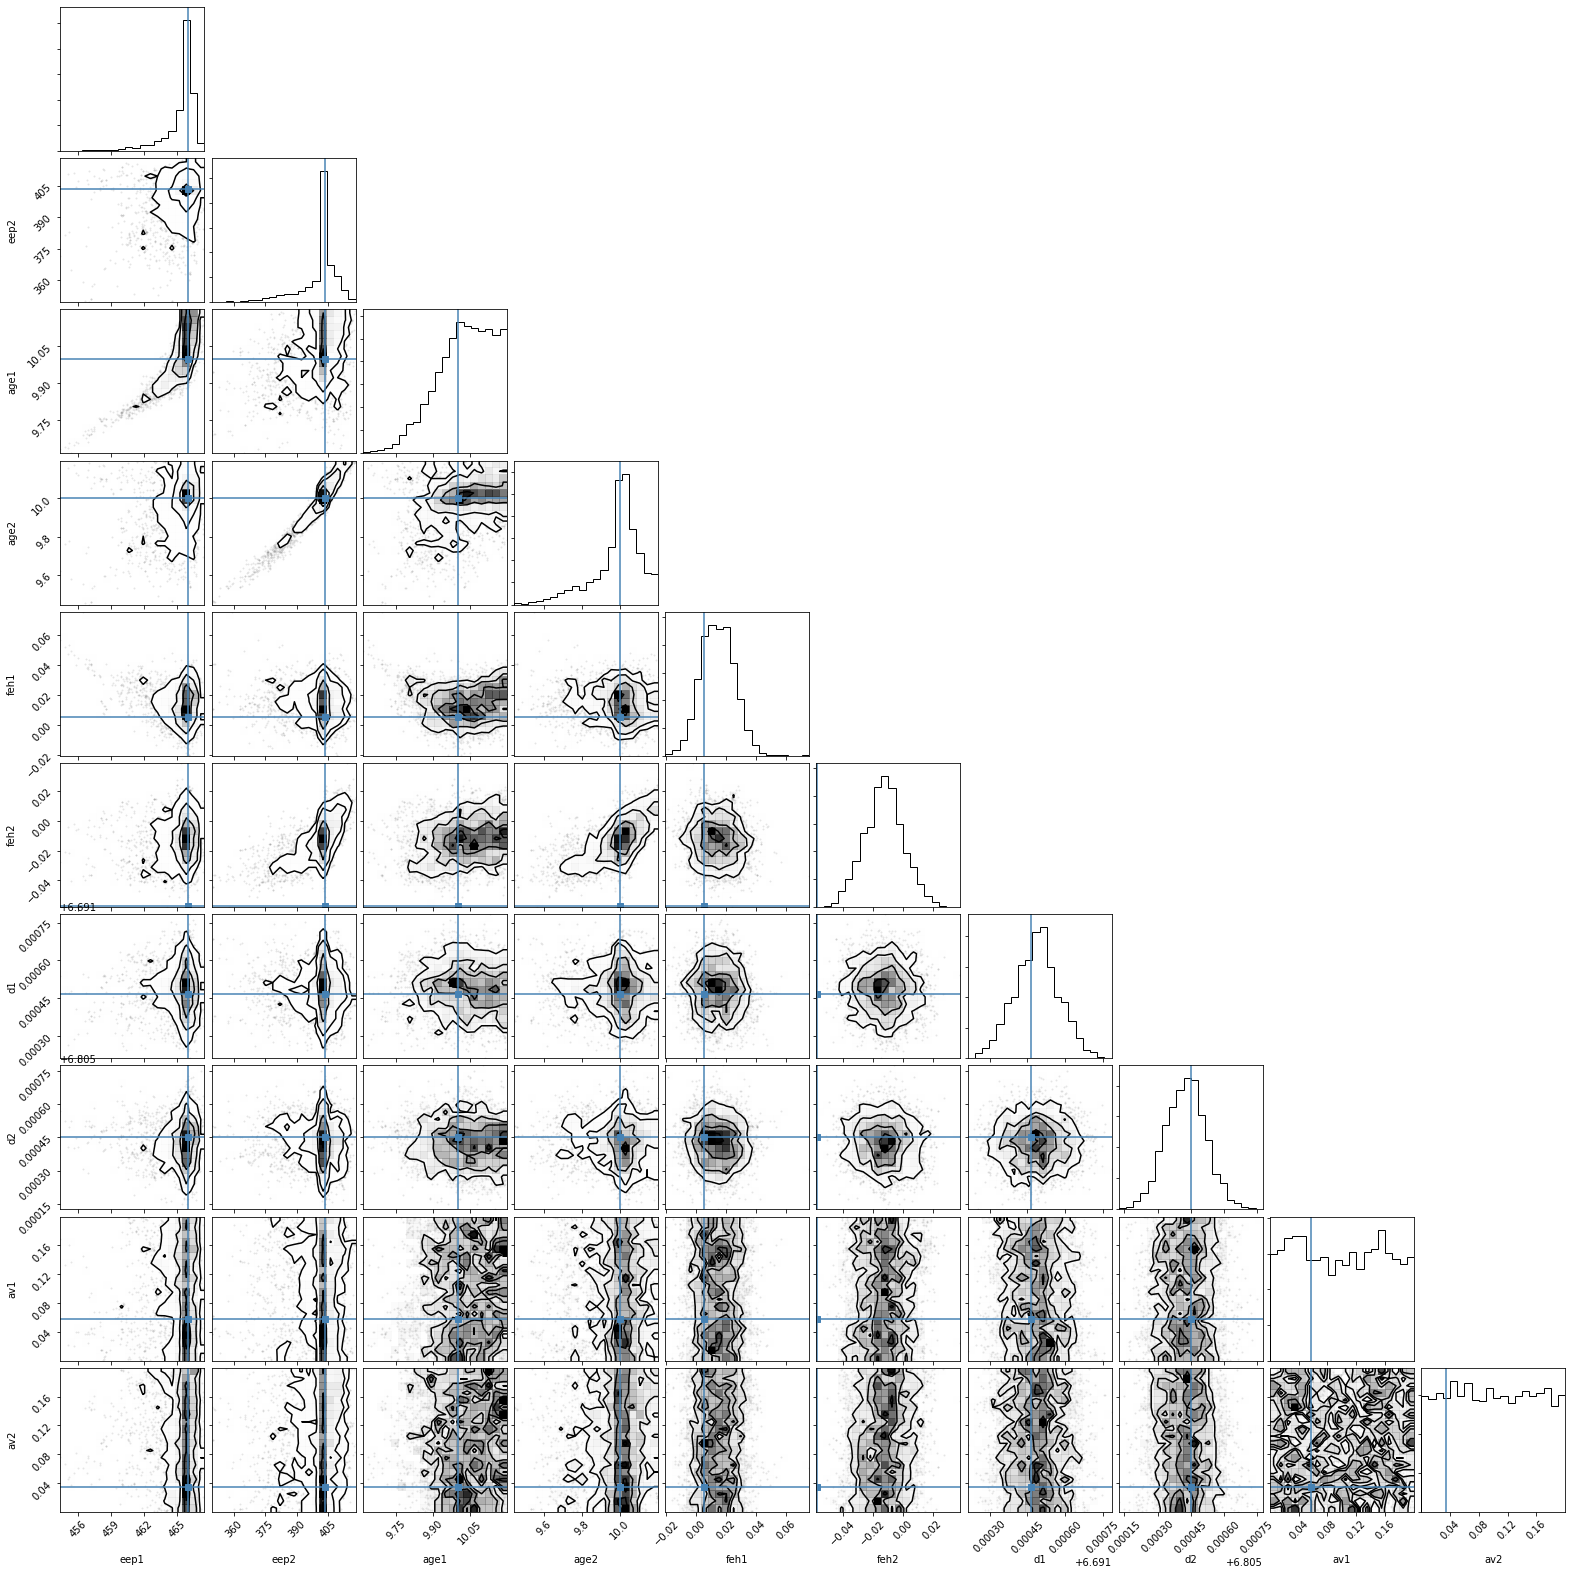

In [206]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["eep1", "eep2", "age1", "age2", "feh1", "feh2", "d1", "d2", "av1", "av2"]
fig = corner.corner(flat_samples, labels=labels, truths=lnparams2)

Now we want to infer the age of the stellar population. There are two ways to code this up: we could assume that every star has exactly the same age, or that their ages are drawn from a Gaussian distribution, where we infer the mean and sigma of the Gaussian. Let's try the first way. The only change here is that the stars share an age.

In [211]:
params3 = np.array([eep[i1], eep[i2], age[i1], # ONLY ONE AGE PARAMETER
                    feh[i1], feh[i2], d_pc[i1], d_pc[i2], av[i1], av[i2]])

# Log-uniform prior on distance
lnparams3 = np.array([eep[i1], eep[i2], age[i1], # ONLY ONE AGE PARAMETER
                      feh[i1], feh[i2], np.log(d_pc[i1]), np.log(d_pc[i2]), av[i1], av[i2]])

In [212]:
def lnprior3(params):
    #           0      1    2    3      4    5   6   7    8
    # params = eep1, eep2, age, feh1, feh2, d1, d2, av1, av2
    
    if np.all(params[:2] > 195) and np.all(params[:2] < 600) \
        and params[3] > -1 and params[3] < 10.2 \
        and np.all(params[3:5] > -.3) and np.all(params[3:5] < .3) \
        and np.all(params[5:7] > 2) and np.all(params[5:7] < 8) \
        and np.all(params[7:9] > 0) and np.all(params[7:9] < .2):
        return 0
    else:
        return -np.inf

def lnprob3(params, mod1, mod2):
    prior = lnprior3(params)
    p = params*1
    p[5:7] = np.exp(params[5:7])  # Different indices
    like1 = mod1.lnlike(np.array([p[0], p[2], p[3], p[5], p[7]]))  # Different indices
    like2 = mod2.lnlike(np.array([p[1], p[2], p[4], p[6], p[8]]))
    if not np.isfinite(like1) or not np.isfinite(like2):
        return -np.inf
    else:
        return like1 + like2 + prior

# Test the logprob returns a reasonable number (not NaNs or infs)
print(lnprob3(lnparams3, mod1, mod2))

-55.871369570244894


In [213]:
ndim, nwalkers = 9, 50  # One fewer parameter.
p0 = np.random.randn(nwalkers, ndim)*1e-3 + lnparams3

# Should definitely have more samples for the final run!
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=[mod1, mod2])
sampler.run_mcmc(p0, 1000);

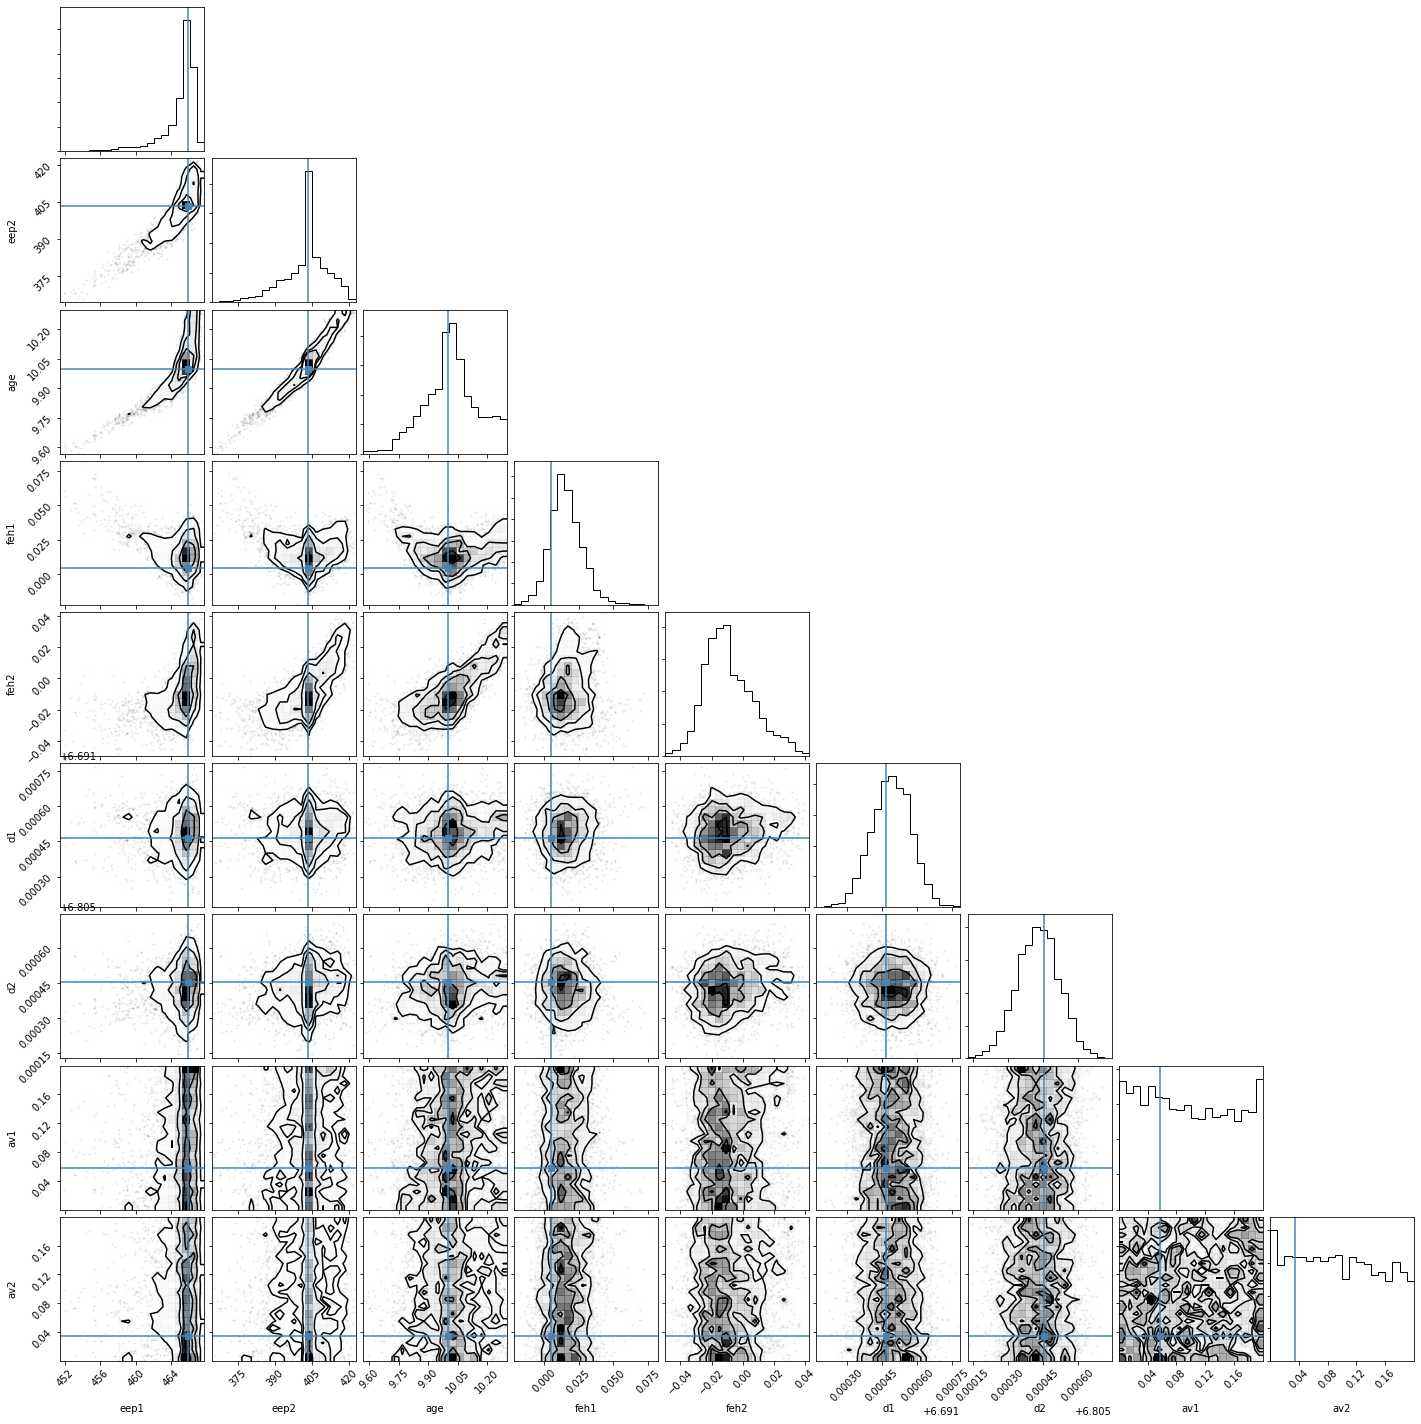

In [214]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["eep1", "eep2", "age", "feh1", "feh2", "d1", "d2", "av1", "av2"]
fig = corner.corner(flat_samples, labels=labels, truths=lnparams3)

Now the second way. We define a Gaussian prior over age, where the mean and sigma of the prior are free parameters.

In [270]:
params4 = np.array([eep[i1], eep[i2], age[i1], age[i2], feh[i1], feh[i2], d_pc[i1], d_pc[i2], av[i1], av[i2],
                    age[i1], 1e-4]) # These last two are age_mu and age_sig.

# Log-uniform prior on distance
lnparams4 = np.array([eep[i1], eep[i2], age[i1], age[i2], feh[i1], feh[i2], np.log(d_pc[i1]), np.log(d_pc[i2]), av[i1], av[i2],
                      age[i1], np.log(1e-4)]) # These last two are age_mu and log(age_sig).

In [271]:
lnparams4

array([ 4.65953577e+02,  4.03618273e+02,  9.99986647e+00,  1.00000380e+01,
        4.93375352e-03, -5.71369956e-02,  6.69146604e+00,  6.80545263e+00,
        5.76981612e-02,  3.45480854e-02,  9.99986647e+00, -9.21034037e+00])

In [272]:
# print(params4[:-2:2])
# print(eep[i1], age[i1], feh[i1], d_pc[i1], av[i1])
# print(params4[1:-2:2])
# print(eep[i2], age[i2], feh[i2], d_pc[i2], av[i2])

In [273]:
# Check this carefully!
def lnGauss(x, mu, s):
    sig = np.exp(s)
    return -.5*(x-mu)**2/sig**2 - np.log(sig)

def lnprior4(params):
    #           0      1    2      3     4     5    6   7   8    9     10      11
    # params = eep1, eep2, age1, age2, feh1, feh2, d1, d2, av1, av2, age_mu, age_sig
    
    # Now you have a hyper-prior over age_mu and age_sig and no prior on indiv. ages
    # because age_mu and age_sig ARE the prior over indiv. ages.
    if np.all(params[:2] > 195) and np.all(params[:2] < 600) \
        and np.all(params[4:6] > -.3) and np.all(params[4:6] < .3) \
        and np.all(params[6:8] > 2) and np.all(params[6:8] < 8) \
        and np.all(params[8:10] > 0) and np.all(params[8:10] < .2) \
        and params[10] > 9.8 and params[10] < 10.2 \
        and params[11] > -10 and params[11] < -9:
        return 0
    else:
        return -np.inf

def lnprob4(params, mod1, mod2):
    prior = lnprior4(params)
    p = params*1
    p[6:8] = np.exp(params[6:8])  # distnace
    like1 = mod1.lnlike(params[:-2:2])  # likelihoods of each star
    like2 = mod2.lnlike(params[1:-2:2])
    
    # Distribution over individual ages:
    age_prior1 = lnGauss(params[2], params[10], params[11])
    age_prior2 = lnGauss(params[3], params[10], params[11])
    
    if not np.isfinite(like1) or not np.isfinite(like2):
        return -np.inf
    else:
        return like1 + like2 + prior + age_prior1 + age_prior2

# Test the logprob returns a reasonable number (not NaNs or infs)
print(lnprob4(lnparams4, mod1, mod2))

-2161568184497.6401


In [274]:
ndim, nwalkers = 12, 50
p0 = np.random.randn(nwalkers, ndim)*1e-3 + lnparams4

# Should definitely have more samples for the final run!
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=[mod1, mod2])
sampler.run_mcmc(p0, 5000);

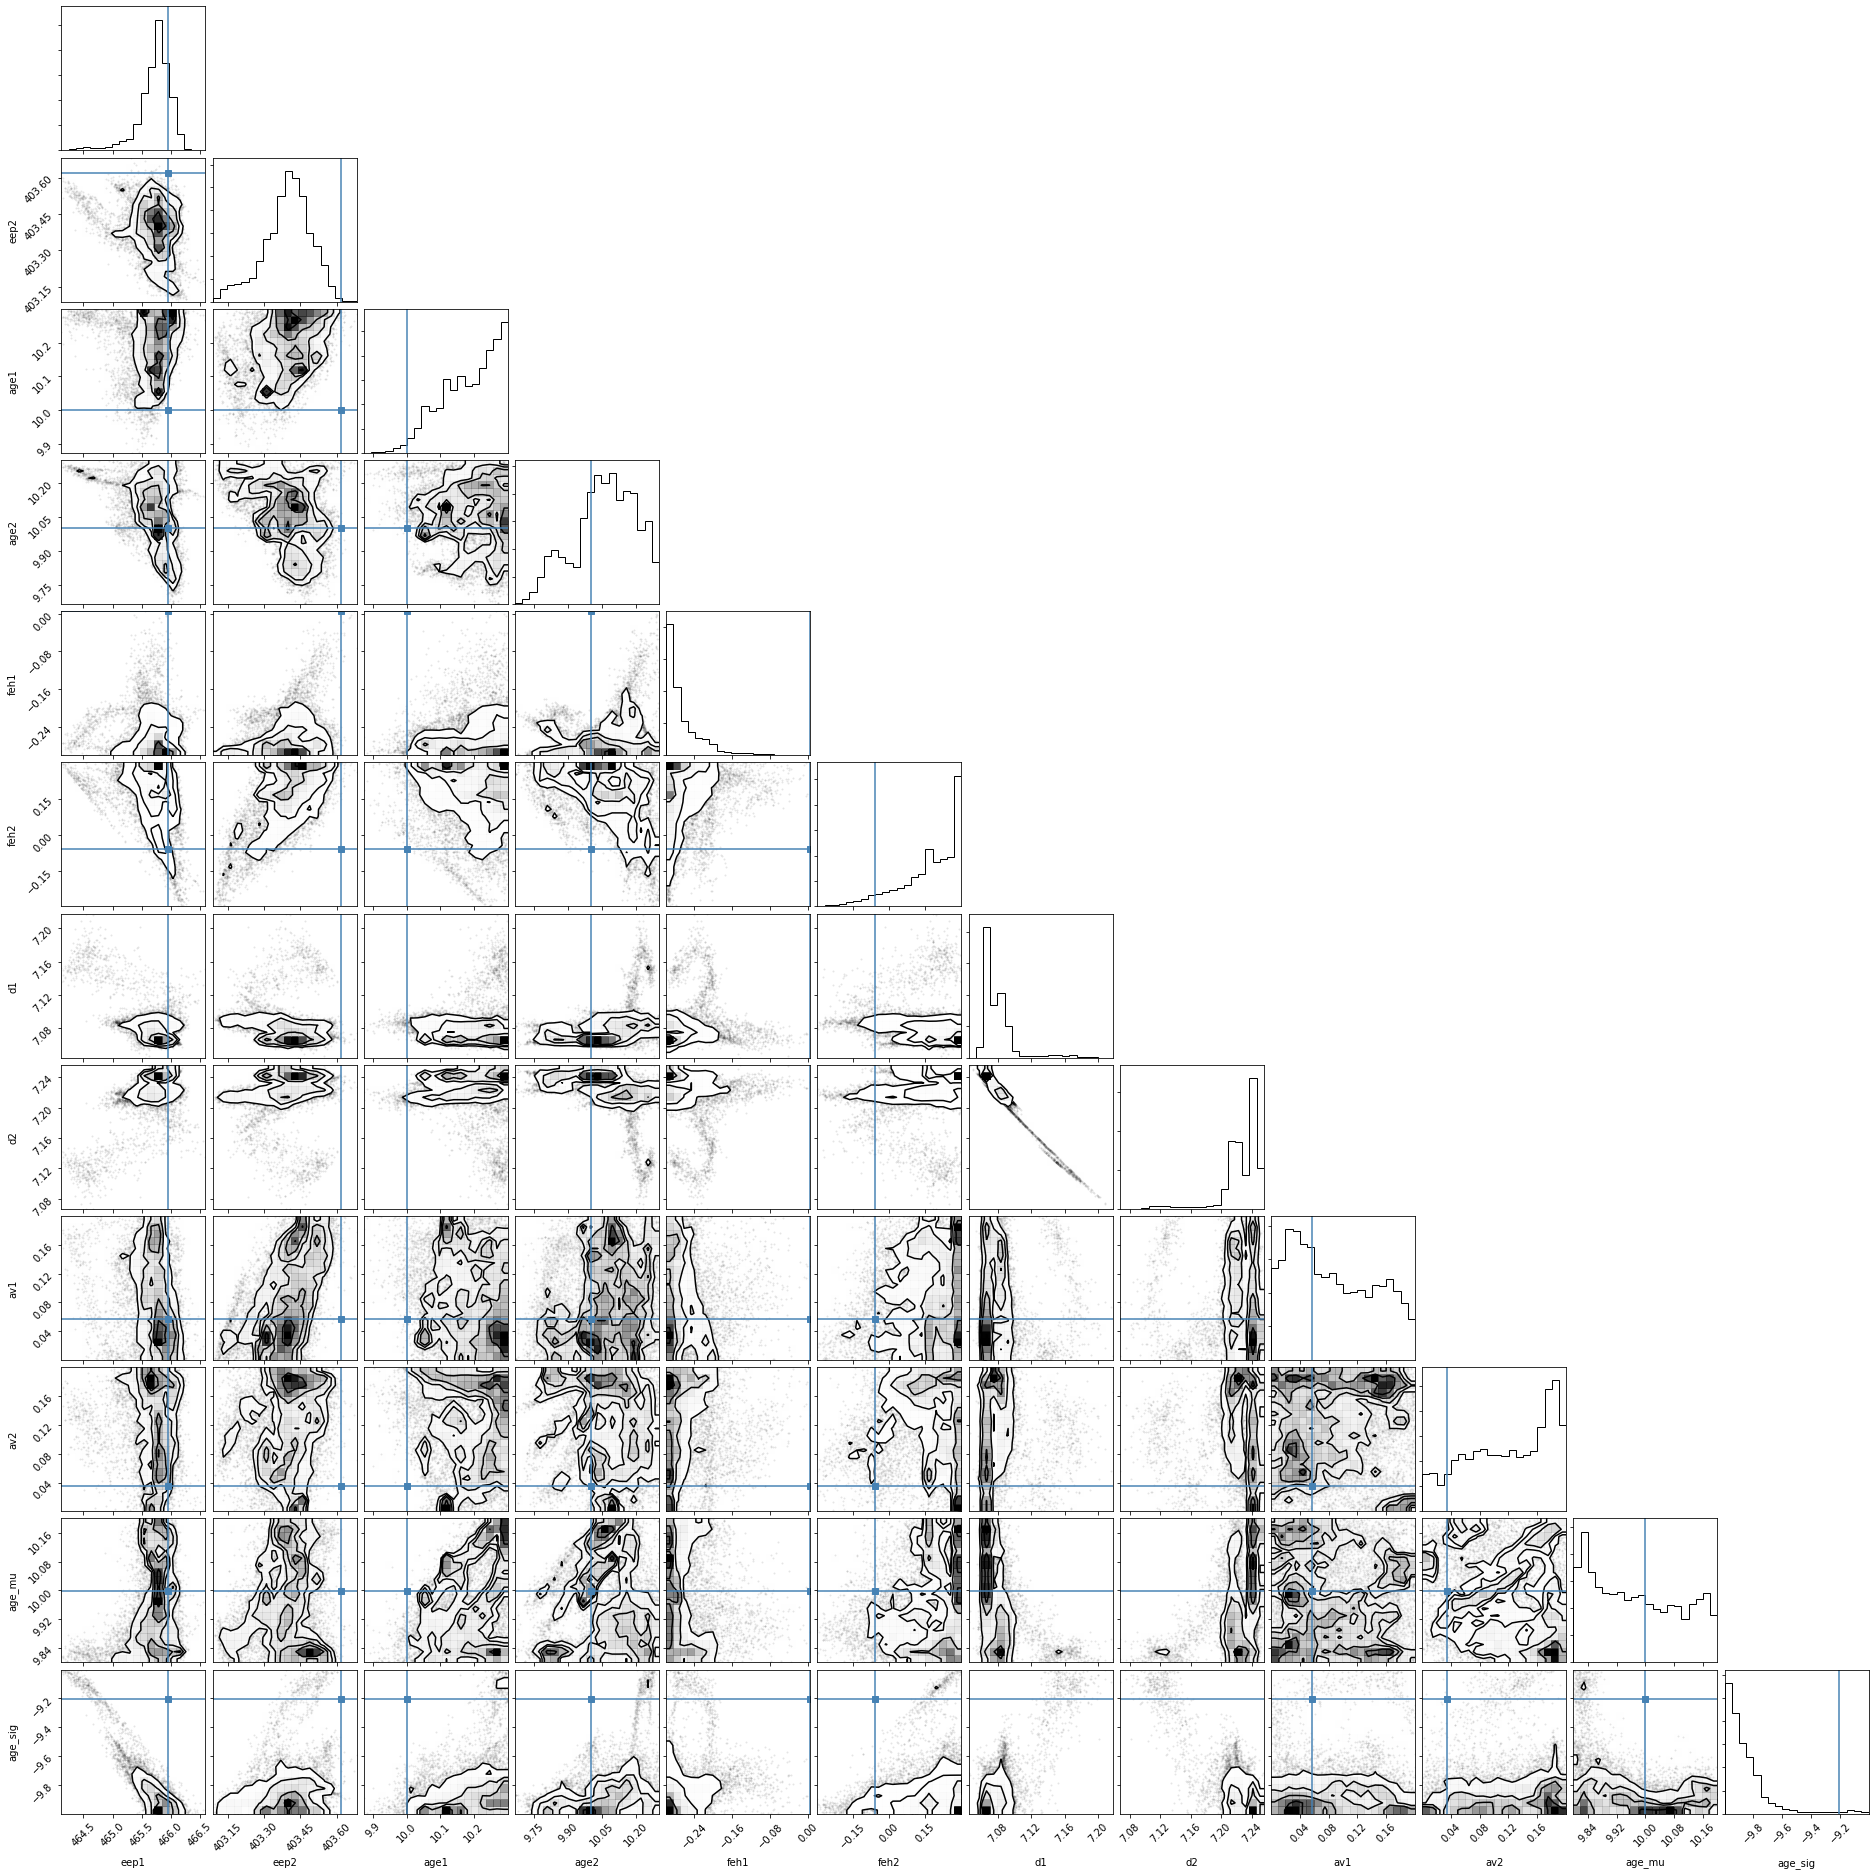

In [275]:
flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)
labels = ["eep1", "eep2", "age1", "age2", "feh1", "feh2", "d1", "d2", "av1", "av2", "age_mu", "age_sig"]
fig = corner.corner(flat_samples, labels=labels, truths=lnparams4)